In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image

import torch
from torch.autograd import Variable
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class CustomCityScapeDS(Dataset):
    def __init__(self, root = None, split = "train", mode = "fine", 
                 transform = None, sematic_transform = None):
        self.split = split
        self.mode = mode
        self.images = []
        self.targets = []
        self.target_transform = {}

        self.semantic_map = {
            0 : ['unlabeled', 19, 'void'], 
            1 : ['ego vehicle', 19, 'void'],
            2 : ['rectification border', 19, 'void'],
            3 : ['out of roi', 19, 'void'],
            4 : ['static', 19, 'void'],
            5 : ['dynamic', 19, 'void'],
            6 : ['ground', 19, 'void'],
            7 : ['road', 0, 'flat'],
            8 : ['sidewalk', 1, 'flat'],
            9 : ['parking', 19, 'flat'],
            10 : ['rail track', 19, 'flat'],
            11 : ['building', 2, 'construction'],
            12 : ['wall', 3, 'construction'],
            13 : ['fence', 4, 'construction'],
            14 : ['guard rail', 19, 'construction'],
            15 : ['bridge', 19, 'construction'],
            16 : ['tunnel', 19, 'construction'],
            17 : ['pole', 5, 'object'],
            18 : ['polegroup', 19, 'object'],
            19 : ['traffic light', 6, 'object'],
            20 : ['traffic sign', 7, 'object'],
            21 : ['vegetation', 8, 'nature'],
            22 : ['terrain', 9, 'nature'],
            23 : ['sky', 10, 'sky'],
            24 : ['person', 11, 'human'],
            25 : ['rider', 12, 'human'],
            26 : ['car', 13, 'vehicle'],
            27 : ['truck', 14, 'vehicle'],
            28 : ['bus', 15, 'vehicle'],
            29 : ['caravan', 19, 'vehicle'],
            30 : ['trailer', 19, 'vehicle'],
            31 : ['train', 16, 'vehicle'],
            32 : ['motorcycle', 17, 'vehicle'],
            33 : ['bicycle', 18, 'vehicle'],
            34 : ['license plate', -1, 'vehicle']
        }
        
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([transforms.Resize((256, 512)), transforms.ToTensor()])
        
        if sematic_transform:
            self.target_transform['semantic'] = sematic_transform
        else:
            self.target_transform['semantic'] = transforms.Compose(
                [transforms.Resize((256, 512)), transforms.PILToTensor(), self.make_semantic_class])

        self.root = "/media/mountHDD2/cityscapes" if not root else root

        if self.mode == "fine":
            if self.split not in ['train', 'val', 'test']:
                raise ValueError("self.split has to be one of ['train', 'val', 'test']")
        elif self.mode == "coarse":
            if self.split not in ['train', 'train_extra', 'val']:
                raise ValueError("self.split has to be one of ['train', 'train_extra', 'val']")
        else:
            raise Value_colorError(f"mode cannot be {self.mode}")

        self.img_dir = self.root + f"/leftImg8bit/{self.split}"
        self.mode_folder = "gtFine" if self.mode == "fine" else "gtCoarse"
        self.semantic_dir = self.root + f"/{self.mode_folder}/{self.split}"
        self.depth_dir = self.root + f"/disparity/{self.split}"

        for check_dir in [self.img_dir, self.semantic_dir, self.depth_dir]:
            if not os.path.exists(check_dir):
                print(f"The dataset source is not available or not extracted at {self.root}")

        print("Data Set Setting Up")
        for city in tqdm(os.listdir(self.img_dir)):
            img_dir = os.path.join(self.img_dir, city)
            semantic_target_dir = os.path.join(self.semantic_dir, city)
            depth_target_dir = os.path.join(self.depth_dir, city)
            for file_name in os.listdir(img_dir):
                self.images.append(os.path.join(img_dir, file_name))

                fn = file_name.split("_leftImg8bit")[0]
                mode_folder = semantic_target_dir.split("/")[-3]

                self.targets.append(
                    {
                        "semantic" : os.path.join(semantic_target_dir, f"{fn}_{mode_folder}_labelIds.png"),
                        "depth" : os.path.join(depth_target_dir, f"{fn}_disparity.png"),
                    }
                )
                
        print("Done")
    
    def make_semantic_class(self, x):
        encx = torch.zeros(x.shape, dtype=torch.long)
        for label in self.semantic_map:
            encx[x == label] = self.semantic_map[label][1]
        onehot = F.one_hot(encx.squeeze(1), 20).permute(0, 3, 1, 2)[0].float()
        return onehot[:-1]

    def process_depth(self, x):
        depth = cv2.imread(x, cv2.IMREAD_UNCHANGED).astype(np.float32)
        depth = cv2.resize(depth, (512, 256))
        depth[depth > 0] = (depth[depth > 0] - 1) / 256
        
        # depth = 0.209313 * 2262.52 / depth

        depth[depth == np.inf] = 0
        depth[depth == np.nan] = 0
        depth[depth < 0] = 0

        # depth = np.minimum(depth, 100) 

        torch_depth = torch.from_numpy(depth).unsqueeze(0) / 255.0

        return torch_depth

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.images[idx]).convert("RGB"))

        target = {}
        target['semantic'] = self.target_transform['semantic'](Image.open(self.targets[idx]['semantic']))
        target['depth'] = self.process_depth(self.targets[idx]['depth'])

        return img, target

In [3]:
train_fine_ds = CustomCityScapeDS(split = 'train', mode = 'fine')
valid_fine_ds = CustomCityScapeDS(split = 'val', mode = 'fine')
test_fine_ds = CustomCityScapeDS(split = 'test', mode = 'fine')

print(len(train_fine_ds))
print(len(valid_fine_ds))
print(len(test_fine_ds))

Data Set Setting Up


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1960.77it/s]


Done
Data Set Setting Up


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1693.76it/s]


Done
Data Set Setting Up


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1346.05it/s]

Done
2975
500
1525


In [4]:
train_fine_dl = DataLoader(train_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_fine_dl = DataLoader(valid_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_fine_dl = DataLoader(test_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Batch: {}".format(len(train_fine_dl)))
print("#Validation Batch: {}".format(len(valid_fine_dl)))
print("#Testing Batch: {}".format(len(test_fine_dl)))

#Training Batch: 93
#Validation Batch: 16
#Testing Batch: 48


data shape: torch.Size([3, 256, 512])
semantic_target shape: torch.Size([19, 256, 512])
depth_target shape: torch.Size([1, 256, 512])
Number classes: 19
Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18])


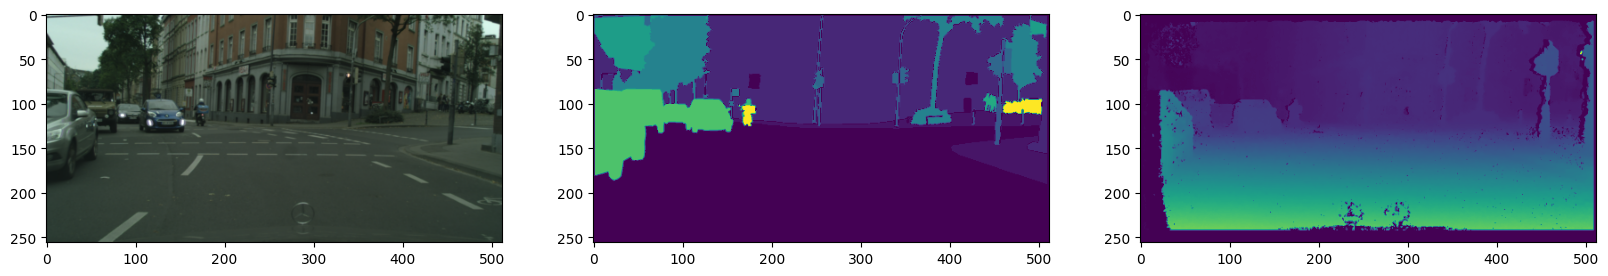

In [5]:
for idx in range(1):
    data, target = train_fine_ds[idx]

    semantic_target = target['semantic']
    depth_target = target['depth']
    
    print(f"data shape: {data.shape}")
    print(f"semantic_target shape: {semantic_target.shape}")
    print(f"depth_target shape: {depth_target.shape}")
    
    num_class = semantic_target.shape[0]
    print(f"Number classes: {num_class}")
    print(f"Classes: {torch.unique(torch.argmax(semantic_target, dim = 0))}")
    
    f, axarr = plt.subplots(1, 3, figsize=(20, 15))
    axarr[0].imshow(data.permute(1, -1, 0).numpy())
    axarr[1].imshow(torch.argmax(semantic_target, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())
    axarr[2].imshow(depth_target.permute(1, -1, 0).numpy())

In [6]:
class Recurrent_block(nn.Module):
    def __init__(self, out_ch, t=2):
        super(Recurrent_block, self).__init__()

        self.t = t
        self.out_ch = out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        for i in range(self.t):
            if i == 0:
                x = self.conv(x)
            out = self.conv(x + x)
        return out

In [7]:
class RRCNN_block(nn.Module):
    def __init__(self, in_ch, out_ch, t=2):
        super(RRCNN_block, self).__init__()

        self.RCNN = nn.Sequential(
            Recurrent_block(out_ch, t=t),
            Recurrent_block(out_ch, t=t)
        )
        self.Conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.Conv(x)
        x2 = self.RCNN(x1)
        out = x1 + x2
        return out

In [8]:
class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [9]:
class R2U_Net(nn.Module):
    def __init__(self, img_ch=3, t=2, ini_filter = 16):
        super(R2U_Net, self).__init__()

        n1 = ini_filter
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(img_ch, filters[0], t=t)

        self.RRCNN2 = RRCNN_block(filters[0], filters[1], t=t)

        self.RRCNN3 = RRCNN_block(filters[1], filters[2], t=t)

        self.RRCNN4 = RRCNN_block(filters[2], filters[3], t=t)

        self.RRCNN5 = RRCNN_block(filters[3], filters[4], t=t)

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_RRCNN5 = RRCNN_block(filters[4], filters[3], t=t)

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_RRCNN4 = RRCNN_block(filters[3], filters[2], t=t)

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_RRCNN3 = RRCNN_block(filters[2], filters[1], t=t)

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_RRCNN2 = RRCNN_block(filters[1], filters[0], t=t)

        self.Conv = nn.Conv2d(filters[0], 1, kernel_size=1, stride=1, padding=0)
    def forward(self, x):

        e1 = self.RRCNN1(x)

        e2 = self.Maxpool(e1)
        e2 = self.RRCNN2(e2)

        e3 = self.Maxpool1(e2)
        e3 = self.RRCNN3(e3)

        e4 = self.Maxpool2(e3)
        e4 = self.RRCNN4(e4)

        e5 = self.Maxpool3(e4)
        e5 = self.RRCNN5(e5)

        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        out = self.Conv(d2)      

        return out

In [10]:
def depth_error(x_pred, x_output):
    binary_mask = (torch.sum(x_output, dim=1) != 0).unsqueeze(1)
    x_pred_true = x_pred.masked_select(binary_mask)
    x_output_true = x_output.masked_select(binary_mask)
    abs_err = torch.abs(x_pred_true - x_output_true)
    rel_err = torch.abs(x_pred_true - x_output_true) / x_output_true
    return (
        torch.sum(abs_err) / torch.nonzero(binary_mask, as_tuple=False).size(0)
    ).item(), (
        torch.sum(rel_err) / torch.nonzero(binary_mask, as_tuple=False).size(0)
    ).item()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = R2U_Net().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.MSELoss()

In [12]:
for epoch in range(10):
    total_train_loss = 0
    total_train_abs_err = 0
    total_train_rel_err = 0
    model.train()
    for i, (train_img, train_depth) in tqdm(enumerate(train_fine_dl)):
        train_img, train_depth = train_img.to(device), train_depth['depth'].to(device)
        
        train_depth_fake = model(train_img)
        
        train_loss = loss_fn(train_depth_fake, train_depth)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()
        train_abs_err, train_rel_err = depth_error(train_depth_fake, train_depth)
        total_train_abs_err += train_abs_err
        total_train_rel_err += train_rel_err
        
    with torch.no_grad():
        model.eval()
        total_valid_loss = 0
        total_valid_abs_err = 0
        total_valid_rel_err = 0
        for i, (valid_img, valid_depth) in tqdm(enumerate(valid_fine_dl)):
            valid_img, valid_depth = valid_img.to(device), valid_depth['depth'].to(device)
            
            valid_depth_fake = model(valid_img)
            
            valid_loss = loss_fn(valid_depth_fake, valid_depth)
            total_valid_loss += valid_loss.item()

            valid_abs_err, valid_rel_err = depth_error(train_depth_fake, train_depth)
            total_valid_abs_err += valid_abs_err
            total_valid_rel_err += valid_rel_err

    print(f"Epoch: {epoch} - Train Loss: {total_train_loss/len(train_fine_dl)} - Valid Loss: {total_valid_loss/len(valid_fine_dl)}")
    print(f"Epoch: {epoch} - Tr_Abs_Err: {total_train_abs_err/len(train_fine_dl)} - Va_Abs_Err: {total_valid_abs_err/len(valid_fine_dl)}")
    print(f"Epoch: {epoch} - Tr_Rel_Err: {total_train_rel_err/len(train_fine_dl)} - Va_Rel_Err: {total_valid_rel_err/len(valid_fine_dl)}")

93it [00:54,  1.72it/s]
16it [00:07,  2.11it/s]

Epoch: 0 - Train Loss: 0.008656854290635355 - Valid Loss: 0.017579876584932208
Epoch: 0 - Tr_Abs_Err: 0.04953128836488211 - Va_Abs_Err: 0.02714657410979271
Epoch: 0 - Tr_Rel_Err: 1.0004070074327531 - Va_Rel_Err: 0.6070716381072998



93it [00:43,  2.12it/s]
16it [00:07,  2.22it/s]

Epoch: 1 - Train Loss: 0.0026529443597981847 - Valid Loss: 0.01753593678586185
Epoch: 1 - Tr_Abs_Err: 0.029263373444317488 - Va_Abs_Err: 0.032251231372356415
Epoch: 1 - Tr_Rel_Err: 0.5135134830269762 - Va_Rel_Err: 0.4421769976615906



93it [00:43,  2.14it/s]
16it [00:07,  2.14it/s]

Epoch: 2 - Train Loss: 0.002315608262565107 - Valid Loss: 0.01648261456284672
Epoch: 2 - Tr_Abs_Err: 0.02672441101442742 - Va_Abs_Err: 0.024926042184233665
Epoch: 2 - Tr_Rel_Err: 0.4669685248405703 - Va_Rel_Err: 0.41248831152915955



93it [00:45,  2.07it/s]
16it [00:07,  2.27it/s]

Epoch: 3 - Train Loss: 0.0021701634646223117 - Valid Loss: 0.015544669819064438
Epoch: 3 - Tr_Abs_Err: 0.025433416949004254 - Va_Abs_Err: 0.024826157838106155
Epoch: 3 - Tr_Rel_Err: 0.43832994084204396 - Va_Rel_Err: 0.40230387449264526



93it [00:44,  2.10it/s]
16it [00:07,  2.07it/s]

Epoch: 4 - Train Loss: 0.0020112637342805024 - Valid Loss: 0.01547969481907785
Epoch: 4 - Tr_Abs_Err: 0.024198198931351785 - Va_Abs_Err: 0.023231597617268562
Epoch: 4 - Tr_Rel_Err: 0.4143678267155924 - Va_Rel_Err: 0.36675432324409485



93it [00:43,  2.13it/s]
16it [00:07,  2.12it/s]

Epoch: 5 - Train Loss: 0.0019021361455401427 - Valid Loss: 0.015004703018348664
Epoch: 5 - Tr_Abs_Err: 0.02331345596460886 - Va_Abs_Err: 0.023976828902959824
Epoch: 5 - Tr_Rel_Err: 0.39814006128618795 - Va_Rel_Err: 0.4109623432159424



93it [00:44,  2.11it/s]
16it [00:07,  2.10it/s]

Epoch: 6 - Train Loss: 0.0018439520893978976 - Valid Loss: 0.016202691476792097
Epoch: 6 - Tr_Abs_Err: 0.022986014784183554 - Va_Abs_Err: 0.02371019683778286
Epoch: 6 - Tr_Rel_Err: 0.39348617580629164 - Va_Rel_Err: 0.3295317590236664



93it [00:43,  2.12it/s]
16it [00:07,  2.22it/s]

Epoch: 7 - Train Loss: 0.0017308419387567268 - Valid Loss: 0.014418924984056503
Epoch: 7 - Tr_Abs_Err: 0.022048503000249145 - Va_Abs_Err: 0.023632630705833435
Epoch: 7 - Tr_Rel_Err: 0.37376027530239475 - Va_Rel_Err: 0.39133256673812866



93it [00:44,  2.10it/s]
16it [00:07,  2.19it/s]

Epoch: 8 - Train Loss: 0.0016981665037512298 - Valid Loss: 0.01423051196616143
Epoch: 8 - Tr_Abs_Err: 0.021694840542891974 - Va_Abs_Err: 0.022970834746956825
Epoch: 8 - Tr_Rel_Err: 0.36459969705150974 - Va_Rel_Err: 0.35032349824905396



93it [00:43,  2.13it/s]
16it [00:07,  2.13it/s]

Epoch: 9 - Train Loss: 0.0016617823069194151 - Valid Loss: 0.013759290450252593
Epoch: 9 - Tr_Abs_Err: 0.02134340238426962 - Va_Abs_Err: 0.019811730831861496
Epoch: 9 - Tr_Rel_Err: 0.35706105251466075 - Va_Rel_Err: 0.35743391513824463


In [13]:
with torch.no_grad():
    model.eval()
    total_test_loss = 0
    for i, (test_img, test_depth) in tqdm(enumerate(test_fine_dl)):
        test_img, test_depth = test_img.to(device), test_depth['depth'].to(device)
        
        test_depth_fake = model(test_img)        
        
        test_loss = loss_fn(test_depth_fake, test_depth)
        total_test_loss += test_loss.item()
print(f"Test Loss: {total_test_loss/len(test_fine_dl)}")

48it [00:14,  3.24it/s]

Test Loss: 0.013538232014980167


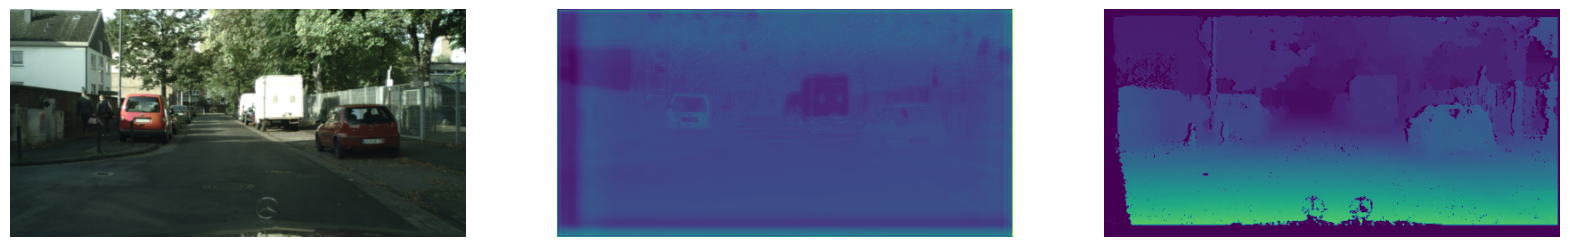

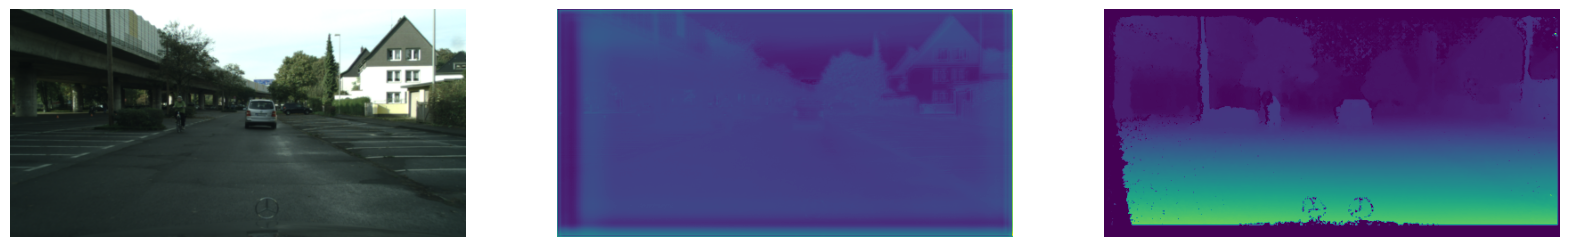

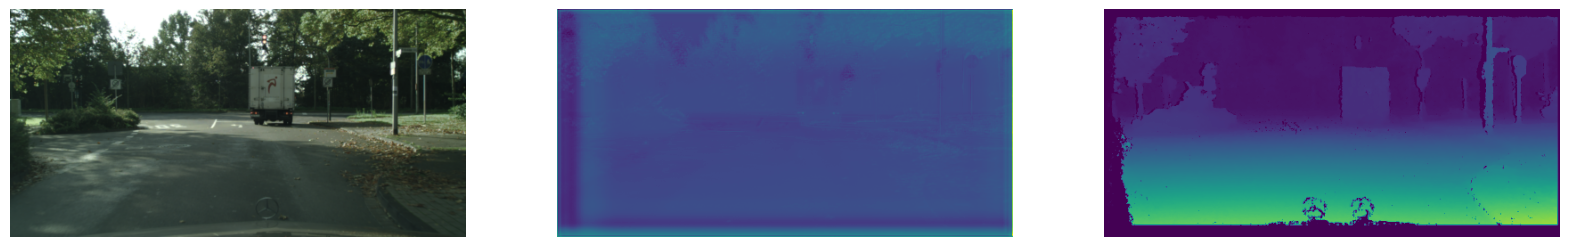

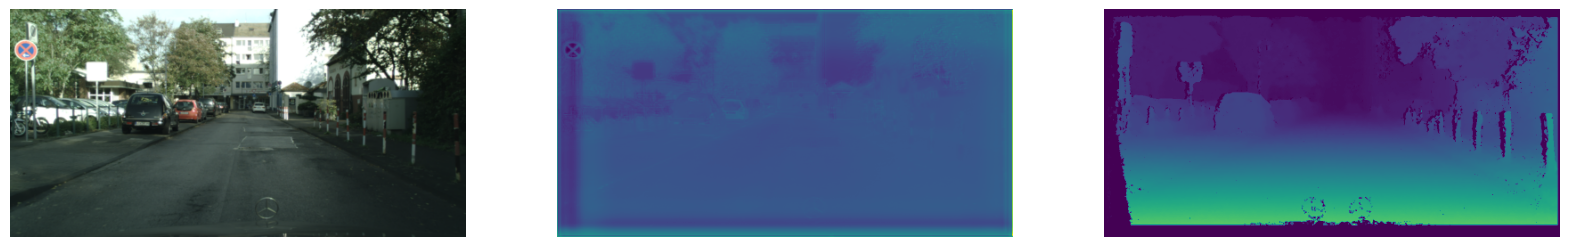

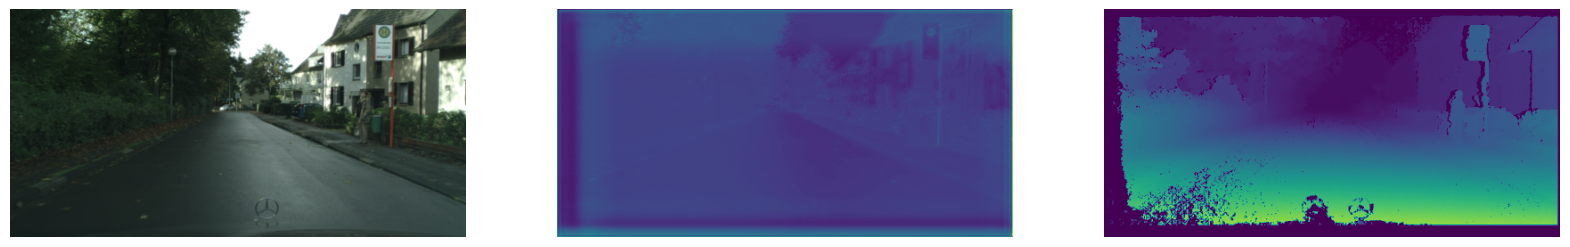

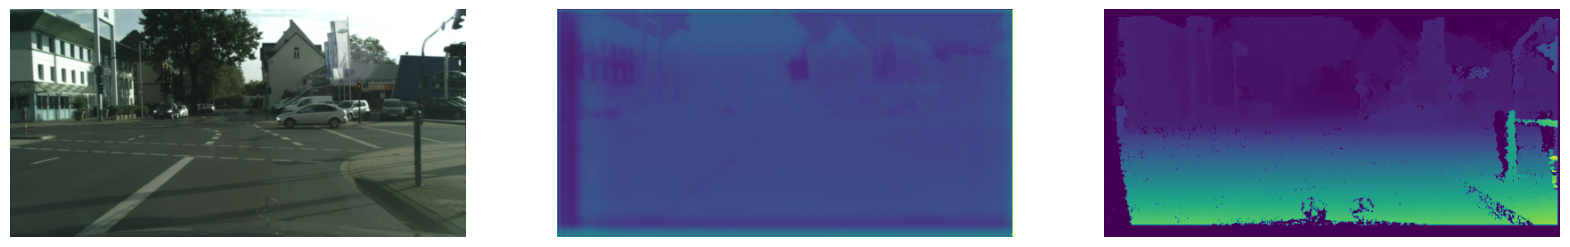

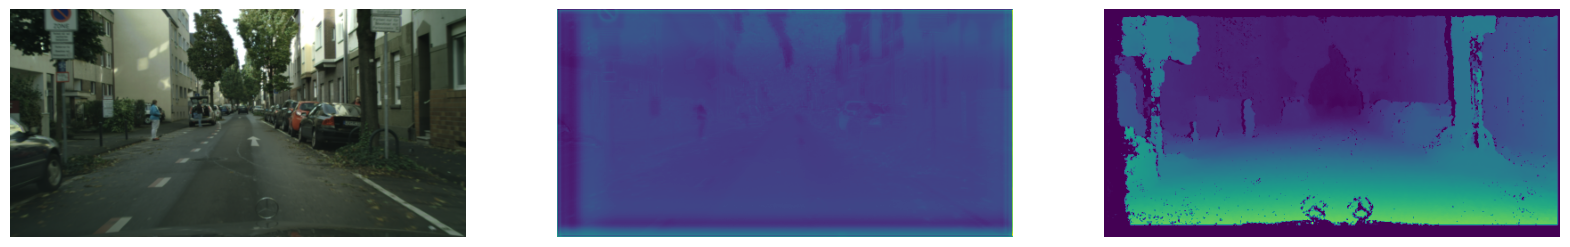

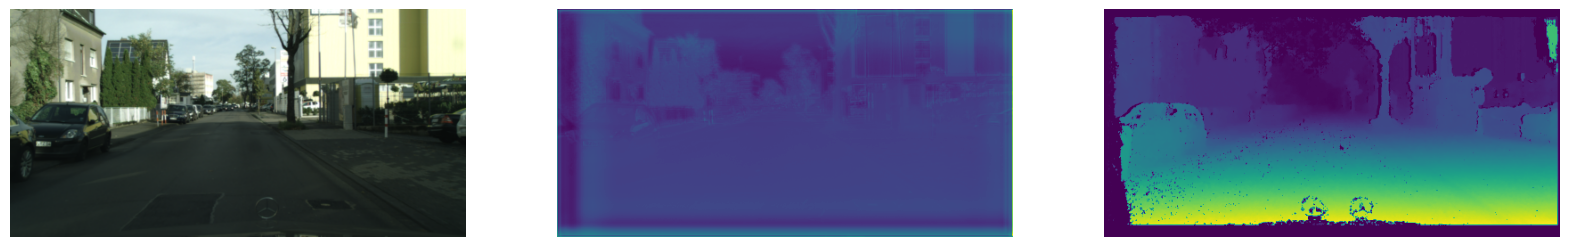

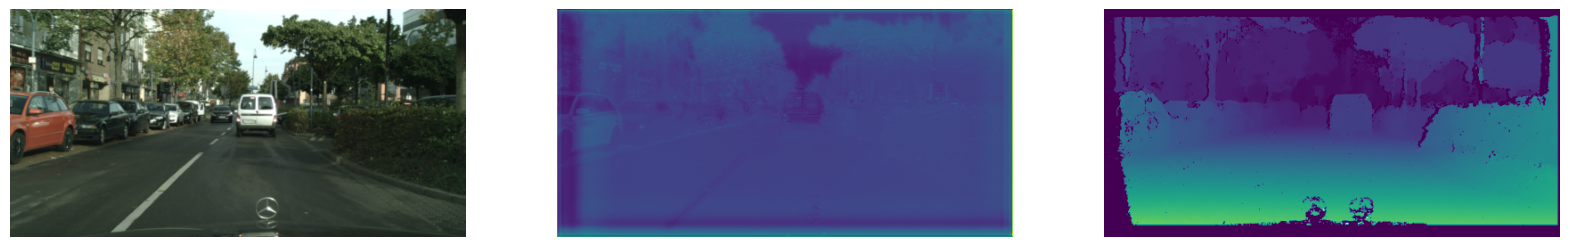

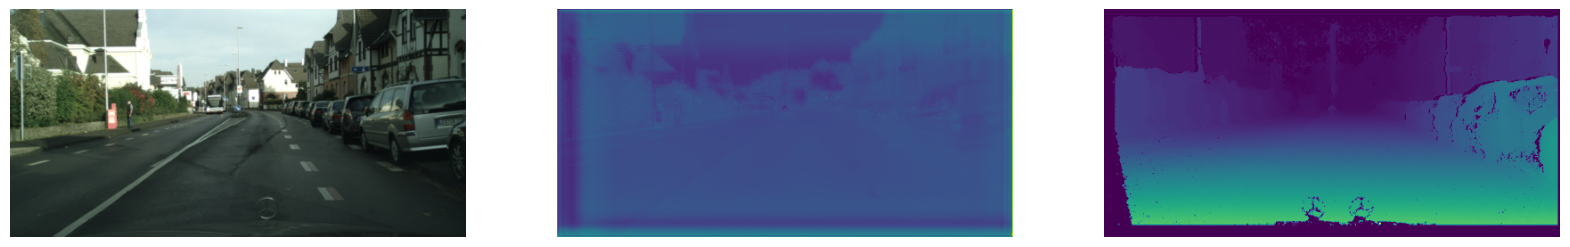

In [14]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        test_img, test_depth = test_fine_ds[test_case_idx]
        test_img = test_img.unsqueeze(dim=0).to(device)
        test_depth = test_depth['depth']

        test_depth_fake = model(test_img)     
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(test_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(test_depth_fake[0].permute(1, -1, 0).cpu().numpy())
        axarr[1].axis('off')
        axarr[2].imshow(test_depth.permute(1, -1, 0).cpu().numpy())
        axarr[2].axis('off')